In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from glob import glob
from PIL import Image
from random import shuffle
from scipy.stats import pearsonr

In [3]:
# census data
CEN_IN_DIR = 'data/Experiment0/census.csv'
# census index data
IDX_IN_DIR = 'data/Experiment0/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment0/aoi_download_log.csv'

# output path
OUT_DIR = 'data/Experiment0/Output/'
# score cutoff
SCORE_CUTOFF = 0.2

# satellite derived data
SAT_IN_DIR = 'data/GoogleStaticMapLarge/Pred/infer/'

In [4]:
# read image index data frame
df_idx = pd.merge(pd.read_csv(IDX_IN_DIR),
                  pd.read_csv(LOG_IN_DIR),
                  how='outer', on='index')
df_idx = df_idx.loc[:, ['index', 'ent', 'mun', 'loc', 'chip', 'status']]

In [5]:
# read census data
df_cen = pd.read_csv(CEN_IN_DIR)

In [6]:
# drop NA localities with no images
df_cen = pd.merge(
    df_cen,
    df_idx.groupby(['ent', 'mun', 'loc']).agg(
        no_missing=pd.NamedAgg(column='status',
                               aggfunc=lambda x: sum(pd.isna(x)))),
    how='outer',
    on=['ent', 'mun', 'loc'])
df_cen = df_cen.loc[df_cen['no_missing'] == 0, :]

In [7]:
# read satellite predictions
# from json annotations
df_sat = []
for file_name in glob(SAT_IN_DIR + '*.json'):
    with open(file_name, 'r') as f:
        df_sat += json.load(f)
df_sat = pd.DataFrame(df_sat)

In [8]:
# drop low score predictions
df_sat = df_sat.loc[df_sat['score'] > SCORE_CUTOFF, :]

In [9]:
# drop predictions on logos
df_sat = pd.concat([
    df_sat.reset_index(),
    pd.DataFrame(df_sat['bbox'].values.tolist(),
                 columns=['xmin', 'ymin', 'width', 'height'])],
    axis=1)
df_sat = df_sat.loc[~((df_sat['xmin'] > 570) & (df_sat['ymin'] > 770)), :]

In [10]:
# merge with locality identifiers
df_sat = pd.merge(
    df_idx.loc[:, ['index', 'ent', 'mun', 'loc']],
    df_sat,
    how='right', left_on='index', right_on='image_id_str')

In [11]:
# merge satellite and census
df = pd.merge(df_sat, df_cen, how='right', on=['ent', 'mun', 'loc'])

In [12]:
# grouping into localities
df_group = df.groupby(['ent', 'mun', 'loc', 'sample']).agg(
    cen_pop=pd.NamedAgg(column='POBTOT', aggfunc=np.nanmean),
    cen_house=pd.NamedAgg(column='VIVTOT', aggfunc=np.nanmean),
    cen_inhab=pd.NamedAgg(column='TVIVHAB', aggfunc=np.nanmean),
    cen_asset=pd.NamedAgg(column='asset_score', aggfunc=np.nanmean),
    cen_vph_snbien=pd.NamedAgg(column='VPH_SNBIEN', aggfunc=np.nanmean),
    cen_vph_1cuart=pd.NamedAgg(column='VPH_1CUART', aggfunc=np.nanmean),
    cen_vph_3ymasc=pd.NamedAgg(column='VPH_3YMASC', aggfunc=np.nanmean),
    cen_vph_refri=pd.NamedAgg(column='VPH_REFRI', aggfunc=np.nanmean),
    cen_vph_autom=pd.NamedAgg(column='VPH_AUTOM', aggfunc=np.nanmean),
    sat_house=pd.NamedAgg(column='score', aggfunc='count'),
    sat_size_mean=pd.NamedAgg(column='area', aggfunc=np.nanmean),
    sat_size_std=pd.NamedAgg(column='area', aggfunc=np.nanstd)
)

In [13]:
# scale areas
df_group['sat_size_mean'] *= (0.298 ** 2) * (640 ** 2) / (800 ** 2) * np.cos(23 / 180 * np.pi)
df_group['sat_size_std'] *= (0.298 ** 2) * (640 ** 2) / (800 ** 2) * np.cos(23 / 180 * np.pi)

In [14]:
# select sample
df_group = pd.concat([
    df_group.xs('new', level='sample')
])

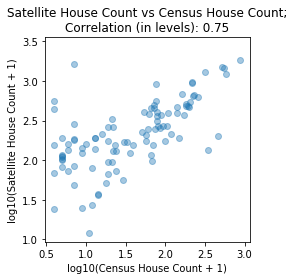

In [15]:
col_x_label = 'Census House Count'
col_x_name = 'cen_house'
col_y_label = 'Satellite House Count'
col_y_name = 'sat_house'
# plotting begins
col_x = df_group.loc[:, col_x_name].values
col_y = df_group.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    np.log10(col_x + 1),
    np.log10(col_y + 1),
    marker='o', linestyle='None', alpha=0.4)
plt.axis('square')
plt.title('{} vs {};\nCorrelation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('log10({} + 1)'.format(col_x_label))
plt.ylabel('log10({} + 1)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))

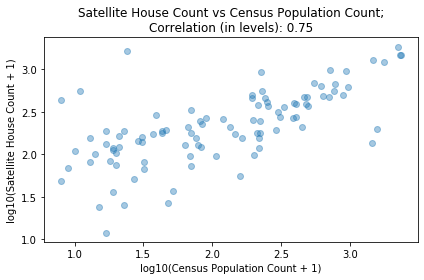

In [16]:
col_x_label = 'Census Population Count'
col_x_name = 'cen_pop'
col_y_label = 'Satellite House Count'
col_y_name = 'sat_house'
# plotting begins
col_x = df_group.loc[:, col_x_name].values
col_y = df_group.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    np.log10(col_x + 1),
    np.log10(col_y + 1),
    marker='o', linestyle='None', alpha=0.4)
plt.title('{} vs {};\nCorrelation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('log10({} + 1)'.format(col_x_label))
plt.ylabel('log10({} + 1)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))

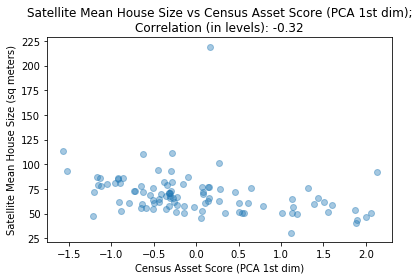

In [17]:
col_x_label = 'Census Asset Score (PCA 1st dim)'
col_x_name = 'cen_asset'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.title('{} vs {};\nCorrelation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{}'.format(col_x_label))
plt.ylabel('{} (sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))

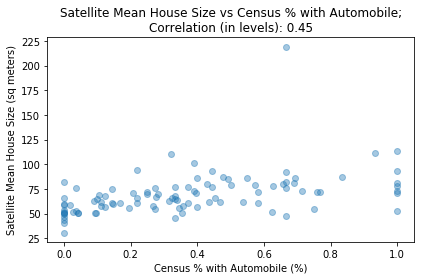

In [18]:
col_x_label = 'Census % with Automobile'
col_x_name = 'cen_vph_autom'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.title('{} vs {};\nCorrelation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))

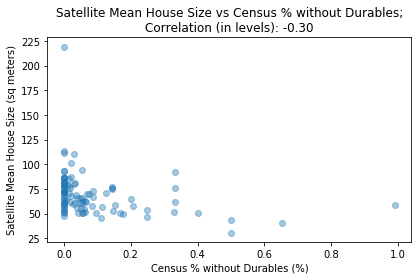

In [19]:
col_x_label = 'Census % without Durables'
col_x_name = 'cen_vph_snbien'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.title('{} vs {};\nCorrelation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))

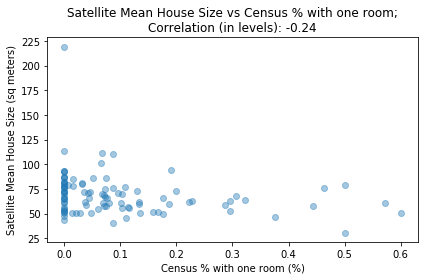

In [20]:
col_x_label = 'Census % with one room'
col_x_name = 'cen_vph_1cuart'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.title('{} vs {};\nCorrelation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))

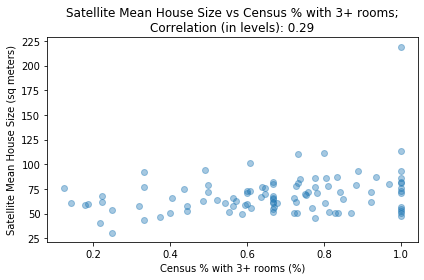

In [21]:
col_x_label = 'Census % with 3+ rooms'
col_x_name = 'cen_vph_3ymasc'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.title('{} vs {};\nCorrelation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))

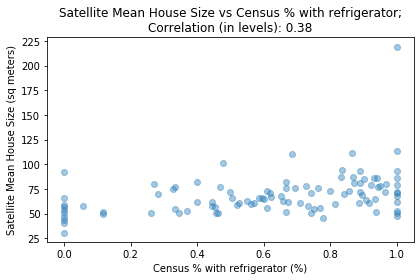

In [22]:
col_x_label = 'Census % with refrigerator'
col_x_name = 'cen_vph_refri'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.title('{} vs {};\nCorrelation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))